What if we make the Russian model x2 deeper and x4 wider? Is its performance going to improve?

In fact, with loss after 250K steps hanging around 6.5, it's not better than the tiny model, that had actually even smaller loss after the same number of steps (that it has also achieved faster). 

Maybe, the problem is that a deeper model just requires longer training, or smaller learning rate, I don't know. But if it's not better than the tiny one, I'll just use the tiny. 

# Load data

In [1]:
import pandas as pd

In [28]:
from tqdm.auto import tqdm, trange
import random
import os
import datasets

In [3]:
all_sents = []
folder = 'C:/Users/david/Documents/nlp/leipzig-corpora/'
for fn in os.listdir(folder):
    with open(folder + fn, 'r') as f:
        for line in tqdm(f):
            text = line.strip().split('\t', 1)[1]
            all_sents.append(text)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [4]:
print(len(all_sents))

3000000


In [29]:
larger_parallel = datasets.load_dataset('AigizK/bashkir-russian-parallel-corpora')

Using custom data configuration AigizK--bashkir-russian-parallel-corpora-4908f7b0980c2b94
Found cached dataset parquet (C:/Users/david/.cache/huggingface/datasets/AigizK___parquet/AigizK--bashkir-russian-parallel-corpora-4908f7b0980c2b94/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

In [32]:
for text in tqdm(larger_parallel['train']['ru']):
    all_sents.append(text)
print(len(all_sents))

  0%|          | 0/702100 [00:00<?, ?it/s]

3702100


In [34]:
for _ in range(5):
    print(random.choice(all_sents))

«Сэра» разрушен до основания – теперь она поет в квартире, как потом выяснится, съемной, но пока.
И этому есть свои причины.
В Башкортостане для празднования Нового года заготовят 143 тысячи елок
Сегодня, обсуждая тему экономики, нельзя обойти стороной и вопрос вокруг банковского кризиса.
Одновременно руководил оркестрами различных шведских воинских подразделений.


# Create a tokenizer

In [6]:
from transformers import T5TokenizerFast, T5ForConditionalGeneration, T5Config

In [7]:
import pandas as pd

In [8]:
tokenizer = T5TokenizerFast.from_pretrained('../models/t5-tiny-rus')

# Initialize a model

In [9]:
cfg = T5Config(
    vocab_size=len(tokenizer),
    d_model=512,
    num_layers=6,
    num_heads=8,
    d_kv=64,
    d_ff=512,
    #feed_forward_proj='gated-gelu',
    decoder_start_token_id=tokenizer.pad_token_id,
)

In [10]:
cfg

T5Config {
  "d_ff": 512,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "num_decoder_layers": 6,
  "num_heads": 8,
  "num_layers": 6,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "transformers_version": "4.26.1",
  "use_cache": true,
  "vocab_size": 32768
}

In [11]:
model = T5ForConditionalGeneration(cfg)

In [12]:
MODEL_SAVE_PATH = '../models/t5-small-rus'

In [13]:
model.save_pretrained(MODEL_SAVE_PATH)
tokenizer.save_pretrained(MODEL_SAVE_PATH)

('../models/t5-small-rus\\tokenizer_config.json',
 '../models/t5-small-rus\\special_tokens_map.json',
 '../models/t5-small-rus\\tokenizer.json')

# Define the training task

In [14]:
text = random.choice(all_sents)
text

'После общественных обсуждений тарифы на ж/д грузоперевозки могут возрасти до 18-20 млрд в год.'

In [15]:
def fill_gap_task(text=None, min_sent_len=3, p_num_words=0.5, left_pad=0, right_pad=0, mask_token='<extra_id_0>'):
    if text is None:
        text = random.choice(all_sents)
    words = text.split()
    if len(words) < min_sent_len:
        return fill_gap_task()
    # to choose between all substrings uniformly, pick both ends uniformly and re-pick if the order is incorrect.
    left_id, right_id = 1, -1
    while left_id > right_id:
        left_id, right_id = [random.randint(left_pad, len(words)-1-right_pad) for _ in range(2)]
    #left_id = random.randint(left_pad, right_id)
    if random.random() > p_num_words:
        filler = [mask_token]
    else:
        filler = [mask_token.replace('0', str(right_id-left_id+1))]
    lhs = ' '.join(words[:left_id] + filler + words[right_id+1:])
    rhs = ' '.join(words[left_id:(right_id+1)])
    return lhs, rhs

In [16]:
from collections import Counter

for t in sorted([(x, y, c) for (x, y), c in Counter(fill_gap_task(text, p_num_words=0) for _ in range(10000)).most_common()]):
    print(t)

('<extra_id_0>', 'После общественных обсуждений тарифы на ж/д грузоперевозки могут возрасти до 18-20 млрд в год.', 96)
('<extra_id_0> 18-20 млрд в год.', 'После общественных обсуждений тарифы на ж/д грузоперевозки могут возрасти до', 95)
('<extra_id_0> в год.', 'После общественных обсуждений тарифы на ж/д грузоперевозки могут возрасти до 18-20 млрд', 100)
('<extra_id_0> возрасти до 18-20 млрд в год.', 'После общественных обсуждений тарифы на ж/д грузоперевозки могут', 118)
('<extra_id_0> год.', 'После общественных обсуждений тарифы на ж/д грузоперевозки могут возрасти до 18-20 млрд в', 105)
('<extra_id_0> грузоперевозки могут возрасти до 18-20 млрд в год.', 'После общественных обсуждений тарифы на ж/д', 88)
('<extra_id_0> до 18-20 млрд в год.', 'После общественных обсуждений тарифы на ж/д грузоперевозки могут возрасти', 85)
('<extra_id_0> ж/д грузоперевозки могут возрасти до 18-20 млрд в год.', 'После общественных обсуждений тарифы на', 97)
('<extra_id_0> млрд в год.', 'После обществен

# Training

In [17]:
import numpy as np
import torch
from tqdm.auto import tqdm, trange
from transformers.optimization import Adafactor, AdamW
from transformers import get_linear_schedule_with_warmup, get_constant_schedule_with_warmup

import gc
import numpy as np

def cleanup():
    gc.collect()
    torch.cuda.empty_cache()
    
cleanup()

In [18]:
model.cuda();

In [19]:
optimizer = torch.optim.AdamW(
    [p for p in model.parameters() if p.requires_grad],  
    lr=1e-3,
    weight_decay=1e-3,
)

In [52]:
batch_size = 16 # we can get even more, but training gets slow
max_length = 64
warmup_steps = 5_000
training_steps = 500_000

In [21]:
losses = []

In [22]:
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=training_steps)

In [23]:
def get_batch_pairs(batch_size, p=0.5):
    xx, yy = [], []
    for text in random.sample(all_sents, batch_size):
        x, y = fill_gap_task(text, p_num_words=p)
        xx.append(x)
        yy.append(y)
    return xx, yy

In [24]:
get_batch_pairs(3)

(['По существу представляет попытку механизации обработки больших массивов <extra_id_0> работу с двумерными массивами.',
  'Под его руководством в ИППИ получили дальнейшее развитие ряд новых направлений исследований, <extra_id_0> по помехоустойчивому кодированию и распознаванию образов.',
  'В 1984 году состоялось освящение новой евангелизационной палатки, вмещающей 34 <extra_id_0> человек.'],
 ['данных,', 'в том числе', 'тысячи'])

In [25]:
# optimizer.param_groups[0]['lr'] = 1e-3  # did this at about 43k step\s

In [117]:
model.train()

tq = trange(len(losses), training_steps)
for i in tq:
    xx, yy = get_batch_pairs(batch_size)
    try:
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y.input_ids[y.input_ids == 0] = -100
        
        loss = model(**x, labels=y.input_ids).loss

        loss.backward()
        losses.append(loss.item())

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy))
        continue

    if i % 1000 == 0:
        print(i, np.mean(losses[-1000:]))

    if i % 10000 == 0 and i > 0:
        model.save_pretrained(MODEL_SAVE_PATH)
        tokenizer.save_pretrained(MODEL_SAVE_PATH)

  0%|          | 0/265118 [00:00<?, ?it/s]

235000 6.548920355319977
236000 6.567369338035584
237000 6.54807213640213
238000 6.5500319790840145
239000 6.533667087554932
240000 6.556890660762787
241000 6.556063564300537
242000 6.541131260871887
243000 6.537235252380371
244000 6.551750202178955
245000 6.525691481113434
246000 6.527601932048798
247000 6.531567666530609


KeyboardInterrupt: 

247792


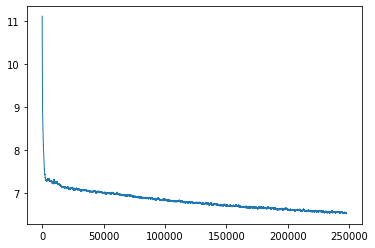

In [118]:
print(len(losses))
pd.Series(losses).ewm(300).mean()[10:].plot(lw=1);

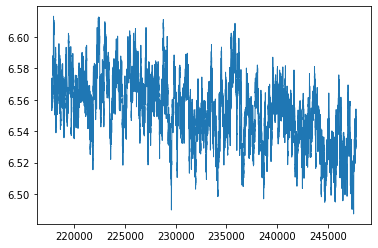

In [119]:
pd.Series(losses).ewm(100).mean()[-30000:].plot(lw=1);

In [120]:
sent = random.choice(all_sents)
sent

'Сборная Белоруссии проиграла Великобритании на чемпионате мира по хоккею, который проходит в Риге.'

In [124]:
xx, yy = fill_gap_task(sent, p_num_words=0.5)
print(xx)
print(yy)

Сборная Белоруссии проиграла <extra_id_0> Риге.
Великобритании на чемпионате мира по хоккею, который проходит в


In [125]:
model.eval();

with torch.inference_mode():
    x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
    for _ in range(5):
        print(tokenizer.decode(model.generate(**x, num_beams=1, do_sample=True)[0]))

<pad> Здесь о него</s>
<pad> Ина,</s>
<pad> о чём</s>
<pad> –</s>
<pad> Этот, поэтому, я</s>


In [47]:
print(tokenizer.tokenize(xx))

['▁Сам', '▁Да', 'кар', '▁был', '▁отдел', 'ен', '<extra_id_0>', '▁18', '87', '▁году', '.']


In [49]:
optimizer.zero_grad(set_to_none=True)
x, y, loss = None, None, None
cleanup()

In [50]:
for k, v in list(globals().items()):
    if isinstance(v, torch.Tensor):
        print(k, v.shape)